In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
batch_size = 64
learning_rate = 0.001

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
train_trans = transforms.Compose(
    [
     transforms.RandomResizedCrop((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

val_trans = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.CenterCrop((224, 224)),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

In [ ]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/train',
                                 transform=train_trans,
                                 )

val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/val',
                                 transform=val_trans,
                                 )

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/test',
                                 transform=val_trans,
                                 )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [ ]:
class conv_block (nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              )

        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.hs = nn.Hardswish()

    def forward(self, X):
        out = self.hs(self.bn(self.conv(X)))

        return out

class SElayer (nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SElayer, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(output_size=1)

        # excitation
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=in_channels,
                                out_features=in_channels//reduction)
        self.fc2 = nn.Linear(in_features=in_channels//reduction,
                             out_features=in_channels)

        self.sigmoid = nn.Sigmoid()

    def forward (self, X):

        out = self.squeeze(X)
        # batch_size, channel, _, _ = x.size()
        batch_size, channel, _, _ = X.shape

        out = out.reshape(out.shape[0], -1)
        out = self.relu(self.fc1(out))
        out = self.sigmoid(self.fc2(out))
        # out = out.view(batch_size, channel, 1, 1)
        out = out.reshape(batch_size, channel, 1, 1)

        # element-wise multiplied with X ???
        # out = out.expand(X.size())
        out = out.expand_as(X)

        return X * out

class depthwise_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride,
                 kernel_size, padding, groups=1,
                 act_type1=False):
        super(depthwise_block, self).__init__()

        assert act_type1 == True or act_type1 == False
        self.act_type = act_type1

        # dw

        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=in_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=groups
                               )

        self.bn1 = nn.BatchNorm2d(num_features=in_channels)

        # mobilenet_v3 uses both Hardswish and ReLU

        if act_type1:
            self.relu = nn.ReLU6()

        self.hardswish = nn.Hardswish()

        # pw

        self.conv2 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=(1, 1),
                               stride=(1, 1),
                               padding=(0, 0),
                               )
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, X):

        if self.act_type:
            out = self.relu(self.bn1(self.conv1(X)))
        else:
            out = self.hardswish(self.bn1(self.conv1(X)))

        out = self.bn2(self.conv2(out))

        # mobilev2 doesnt have relu in pw

        return out

class InvertedResidual_block (nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding, block_type1=False,
                 expand_size=72, act_type_=False, use_se=False):
        super(InvertedResidual_block, self).__init__()

        assert block_type1 == True or block_type1 == False
        assert use_se == True or use_se == False
        self.block_type = block_type1
        self.se_layer = use_se

        # expansion

        self.conv1 = conv_block(in_channels=in_channels,
                               out_channels=expand_size,
                                kernel_size=(1,1),
                               stride=(1,1),
                                padding=(0,0))

        # depthwise_block = depthwise + pointwise

        self.convdw = depthwise_block(in_channels=expand_size,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=padding,
                                      groups=expand_size,
                                      act_type1=act_type_)

        if block_type1:
            self.padd_conv = nn.Conv2d(in_channels=in_channels,
                                       out_channels=out_channels,
                                       kernel_size=(1, 1),
                                       stride=(1, 1),
                                       padding=(0, 0))

        if use_se:
            self.se = SElayer(in_channels=out_channels, reduction=16)

    def forward(self, X):

        out = self.conv1(X)
        out = self.convdw(out)

        if self.se_layer:
            out = self.se(out)

        if self.block_type:
            X = self.padd_conv(X)
            out += X
            return out
        else:
            return out

class mobilenet_v3_small (nn.Module):
    def __init__(self, in_channels, num_classes):
        super(mobilenet_v3_small, self).__init__()

        self.first_layer = conv_block(in_channels=3,
                                      out_channels=16,
                                      kernel_size=(3,3),
                                      stride=(2,2),
                                      padding=(1,1))

        self.bneck1 = InvertedResidual_block(in_channels=16,
                                             out_channels=16,
                                             kernel_size=(3, 3),
                                             stride=(2,2),
                                             padding=(1,1),
                                             block_type1=False,
                                             expand_size=16,
                                             act_type_=True,
                                             use_se=True)

        self.bneck2 = InvertedResidual_block(16, 24, (3,3), (2,2), (1,1),
                                             False, 72, True, False)

        self.bneck3 = InvertedResidual_block(24, 24, (3, 3), (1, 1), (1, 1),
                                             True, 88, True, False)

        self.bneck4 = InvertedResidual_block(24, 40, (5, 5), (2, 2), (2, 2),
                                             False, 96, False, True)

        self.bneck5 = InvertedResidual_block(40, 40, (5, 5), (1, 1), (2, 2),
                                             True, 240, False, True)

        self.bneck6 = InvertedResidual_block(40, 48, (5, 5), (1, 1), (2, 2),
                                             True, 120, False, True)

        self.bneck7 = InvertedResidual_block(48, 48, (5, 5), (1, 1), (2, 2),
                                             True, 144, False, True)

        self.bneck8 = InvertedResidual_block(48, 96, (5, 5), (2, 2), (2, 2),
                                             False, 288, False, True)

        self.bneck9 = InvertedResidual_block(96, 96, (5, 5), (1, 1), (2, 2),
                                             True, 576, False, True)

        self.conv1 = conv_block(in_channels=96,
                                out_channels=576,
                                kernel_size=(1,1),
                                stride=(1, 1),
                                padding=(0, 0))

        self.se = SElayer(in_channels=576, reduction=16)

        self.avgpool = nn.AvgPool2d(kernel_size=(7,7),
                                      stride=(1, 1),
                                      padding=(0, 0))
        self.hardswish = nn.Hardswish()

        self.fc1 = nn.Linear(in_features=576, out_features=1024)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, X):
        out = self.first_layer(X)
        out = self.bneck1(out)
        out = self.bneck2(out)
        out = self.bneck3(out)
        out = self.bneck4(out)
        out = self.bneck5(out)
        out = self.bneck5(out)
        out = self.bneck6(out)
        out = self.bneck7(out)
        out = self.bneck8(out)
        out = self.bneck9(out)
        out = self.bneck9(out)
        out = self.conv1(out)
        out = self.se(out)
        out = self.avgpool(out)

        out = out.reshape(out.shape[0], -1)

        out = self.hardswish(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [ ]:
model = mobilenet_v3_small(in_channels=3,
                 num_classes=2).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# checkpoint = torch.load('/content/drive/MyDrive/mobilenetv1_on_hymeno.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['model_optimizer'])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def calculate_time (time_elapsed):
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    if minutes > 60:
        hours = minutes // 60
        new_minutes = minutes % 60
        print(f'Training complete in {hours:.0f}h {new_minutes:.0f}m {seconds:.0f}s')
    else:
        print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')

In [ ]:
num_epochs = 30
val_acc_hist = []
train_acc_hist = []
loss_train = []
loss_val = []
best_acc = 0.0

In [ ]:
start = time.time()

for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0
    running_corrects = 0

    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        z_scores = model(images)
        loss = criterion(z_scores, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predictions = torch.max(z_scores, 1)
        running_corrects += torch.sum(predictions == labels)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    print(f'Epoch {epoch+1} / {num_epochs}, '
          f'Train Loss {epoch_loss:.4f}, '
          f'Train Acc {epoch_acc:.4f}')

    train_acc_hist.append(epoch_acc)
    loss_train.append(epoch_loss)

    step_lr_scheduler.step()

    model.eval()

    running_loss = 0.0
    running_corrects = 0

    for idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            z_scores = model(images)
            loss = criterion(z_scores, labels)

            running_loss += loss.item() * images.size(0)
            _, predictions = torch.max(z_scores, 1)
            running_corrects += torch.sum(predictions == labels)

    epoch_loss_val = running_loss / len(val_dataset)
    epoch_acc_val = running_corrects / len(val_dataset)
    print(f'Epoch {epoch + 1} / {num_epochs}, '
          f'Val Loss {epoch_loss_val:.4f}, '
          f'Val Acc {epoch_acc_val:.4f}')

    val_acc_hist.append(epoch_acc_val)
    loss_val.append(epoch_loss_val)

    if epoch_acc_val > best_acc:
        best_acc = epoch_acc_val

time_elapsed = time.time() - start

Epoch 1 / 30, Train Loss 0.6986, Train Acc 0.5164
Epoch 1 / 30, Val Loss 0.6957, Val Acc 0.4301
Epoch 2 / 30, Train Loss 0.6816, Train Acc 0.5328
Epoch 2 / 30, Val Loss 0.7025, Val Acc 0.4301
Epoch 3 / 30, Train Loss 0.6620, Train Acc 0.6148
Epoch 3 / 30, Val Loss 0.7316, Val Acc 0.4301
Epoch 4 / 30, Train Loss 0.6471, Train Acc 0.6107
Epoch 4 / 30, Val Loss 0.7190, Val Acc 0.4301
Epoch 5 / 30, Train Loss 0.7147, Train Acc 0.5943
Epoch 5 / 30, Val Loss 0.7113, Val Acc 0.4301
Epoch 6 / 30, Train Loss 0.6415, Train Acc 0.6311
Epoch 6 / 30, Val Loss 0.7247, Val Acc 0.4301
Epoch 7 / 30, Train Loss 0.6262, Train Acc 0.6393
Epoch 7 / 30, Val Loss 0.7676, Val Acc 0.4301
Epoch 8 / 30, Train Loss 0.6147, Train Acc 0.6434
Epoch 8 / 30, Val Loss 0.7784, Val Acc 0.4301
Epoch 9 / 30, Train Loss 0.5931, Train Acc 0.6598
Epoch 9 / 30, Val Loss 0.7734, Val Acc 0.4301
Epoch 10 / 30, Train Loss 0.6060, Train Acc 0.6434
Epoch 10 / 30, Val Loss 0.7610, Val Acc 0.4301
Epoch 11 / 30, Train Loss 0.6050, Trai

In [ ]:
calculate_time(time_elapsed)

Training complete in 2m 51s


In [ ]:
print(f'Best validation Accuracy: {best_acc:.4f}')

Best validation Accuracy: 0.6559


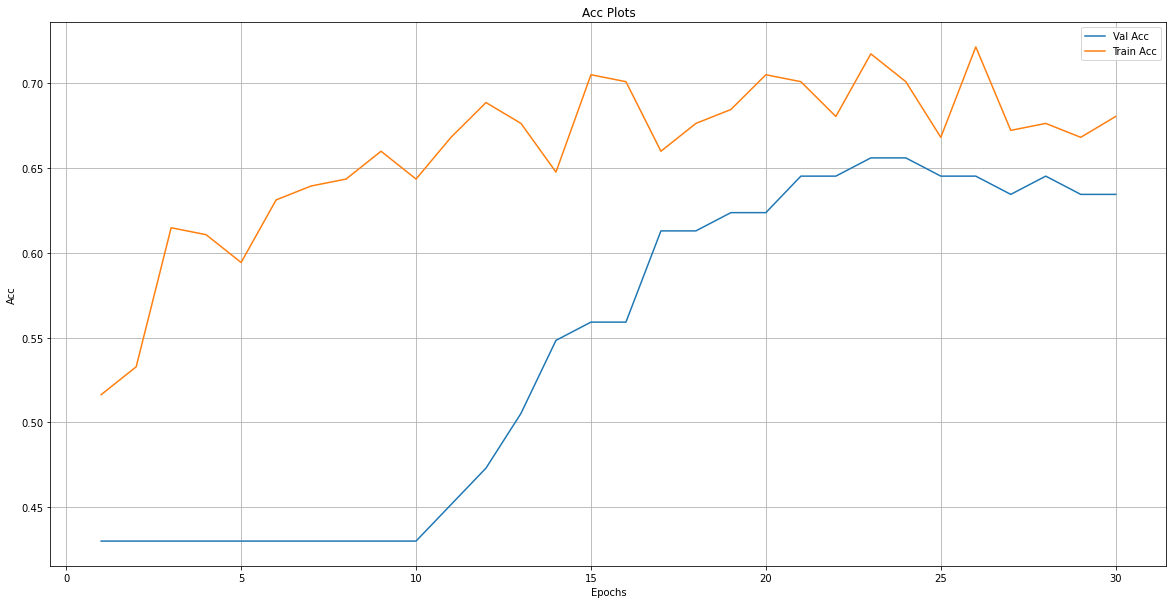

In [ ]:
val_acc_hist_numpy = [acc.cpu().numpy() for acc in val_acc_hist]
train_acc_hist_numpy = [acc.cpu().numpy() for acc in train_acc_hist]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), val_acc_hist_numpy, label='Val Acc')
plt.plot(range(1, num_epochs+1), train_acc_hist_numpy, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title("Acc Plots")
plt.legend(loc='upper right')
plt.show()

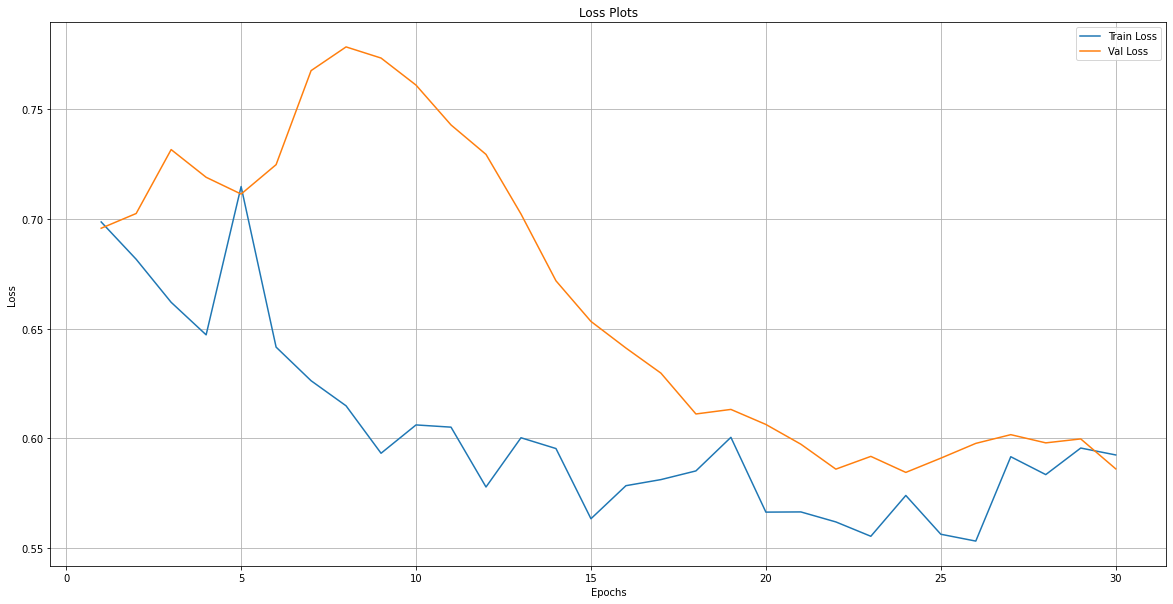

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.eval()

running_corrects = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        z_scores = model(images)

        _, predictions = torch.max(z_scores,1)
        running_corrects += torch.sum(predictions == labels)

    acc = running_corrects / len(test_dataset)
    print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.6333


In [ ]:
checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_optimizer': optimizer.state_dict(),
                'val_acc_hist': val_acc_hist,
                'train_acc_hist': train_acc_hist,
                'loss_train': loss_train,
                'loss_val': loss_val,
                'best_acc': best_acc
}

torch.save(checkpoint, '/content/drive/MyDrive/mobilenetv3_on_hymeno.pth')